In [8]:
import mne
import numpy as np
from scipy import stats
import seaborn as sns
import pandas as pd
import os
import re

# Multiprocessing
import deepgraph as dg
from multiprocessing import Pool
from nancorrmp.nancorrmp import NaNCorrMp
import matplotlib.pyplot as plt

%matplotlib inline



In [2]:
os.listdir("./DataBase")

['SETA', 'SETB', 'SETC', 'SETD']

In [38]:
def get_eeg_file(): 
  rootdir = "./DataBase/"
  sets = os.listdir(rootdir)
  regex = re.compile('(.*out$)')
  dic = []

  for set in sets: 
    for root, dirs, files in os.walk(rootdir+set):
      for file in files:
        if regex.match(file):
          ob = {
            "UID" : file[:-4],
            "set" : set, 
            "filename" : file,
          }
          dic.append(ob)
  return dic

In [58]:
mapping = {
    "SETA" : "HC", 
    "SETB" : "HC", 
    "SETC" : "AD",
    "SETD" : "AD"
}

In [39]:
df = pd.DataFrame(get_eeg_file())
df.head()

,UID,set,filename
0,eeg20o1,SETA,eeg20o1.out
1,eeg21o1,SETA,eeg21o1.out
2,eeg22o1,SETA,eeg22o1.out
3,eeg23o1,SETA,eeg23o1.out
4,eeg24o1,SETA,eeg24o1.out


In [62]:
df["label"] = df["set"].map(mapping)
df.head()

,UID,set,filename,label
0,eeg20o1,SETA,eeg20o1.out,HC
1,eeg21o1,SETA,eeg21o1.out,HC
2,eeg22o1,SETA,eeg22o1.out,HC
3,eeg23o1,SETA,eeg23o1.out,HC
4,eeg24o1,SETA,eeg24o1.out,HC


In [44]:
n_features = 19
n_samples = len(df) 

X_raw = {} 

In [117]:
X_raw

{'eeg20o1': array([[  5.9406,   3.8188,  11.699 , ...,   2.0813,   6.8277,   8.9327],
        [  1.9802,   3.8188,   6.7974, ...,   6.9593,   5.8615,   8.9327],
        [ -0.9901,   5.7605,   2.8758, ...,   9.8862,  10.692 ,   8.9327],
        ...,
        [ -4.9505,  -8.8026,  -3.9869, ..., -16.455 , -15.395 , -16.683 ],
        [ -1.9802,  -4.9191,  -4.9673, ...,  -8.6504, -14.428 , -11.757 ],
        [  2.9703,  -1.0356,   1.8954, ...,  -7.6748, -13.462 , -12.742 ]]),
 'eeg21o1': array([[ 48.515 ,  39.741 ,  26.535 , ...,  22.569 ,  24.944 ,  25.556 ],
        [ 42.574 ,  42.654 ,  29.491 , ...,  23.545 ,  26.858 ,  28.497 ],
        [ 39.604 ,  37.799 ,  36.388 , ...,  19.642 ,  22.073 ,  24.575 ],
        ...,
        [ -9.901 , -15.599 ,  -8.9327, ...,  -7.6748,  -7.5917,  -8.7582],
        [ -8.9109, -15.599 ,  -4.0066, ...,  -9.626 , -13.333 , -10.719 ],
        [ -7.9208,  -9.7735,  -2.0361, ..., -10.602 ,  -3.764 ,  -5.817 ]]),
 'eeg22o1': array([[11.823  , 12.557  , 10.719  

In [45]:
for _, s in df.iterrows(): 
    raw = np.loadtxt("DataBase\{}\{}".format(s["set"], s["filename"]))
    X_raw[s["UID"]] = raw 

In [54]:
X_corr = np.zeros((n_samples,n_features, n_features ))
p_corr = np.zeros(X_corr.shape)

X_corr.shape

(48, 19, 19)

In [55]:
for i, item in enumerate(X_raw.items()): 
    key, value = item
    corr, p = NaNCorrMp.calculate_with_p_value(value.T,  n_jobs=5)
    X_corr[i] += corr
    p_corr[i] += p

<AxesSubplot:>

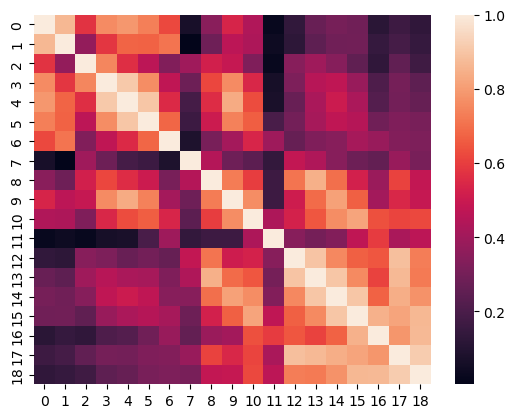

In [57]:
sns.heatmap(X_corr[0])

# Training

In [63]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, classification_report

from torch.utils.data import Dataset


c:\Users\jimmy\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

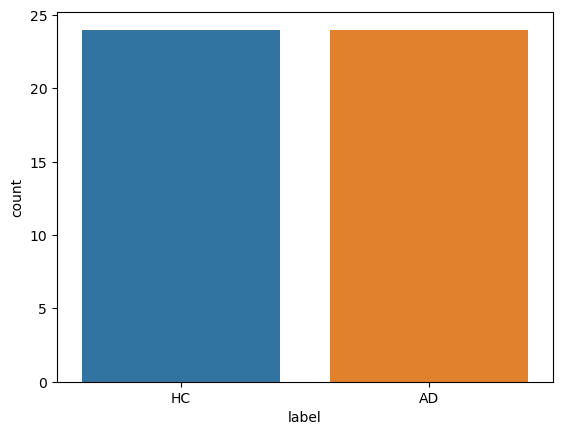

In [64]:
sns.countplot(df["label"])

In [69]:
Y = df["label"].to_numpy()

l_encoder = LabelEncoder()
i_encoded = l_encoder.fit_transform(Y)
print(i_encoded)

Y = i_encoded

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


In [70]:
X = Variable(torch.from_numpy(X_corr.astype(np.float32)), requires_grad=False)
Y = Variable(torch.from_numpy(Y.astype(np.float32)), requires_grad=False)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(   
     X, Y, test_size=0.2, random_state=42)

In [104]:
model = nn.Sequential(
          nn.Conv2d(1,16,3),
          nn.Conv2d(16,16,3),
          nn.MaxPool2d(2),
          nn.Dropout(),
          nn.Conv2d(16,32,3),
          nn.Conv2d(32,32,3),
          nn.MaxPool2d(3),
          nn.Dropout(),
          nn.Flatten(start_dim=0),
          nn.Dropout(),
          nn.Linear(32, 160),
          nn.ReLU(),
          nn.Linear(160, 1),
          nn.Softmax(0)
        )
model.to("cuda")

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.5, inplace=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (6): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.5, inplace=False)
  (8): Flatten(start_dim=0, end_dim=-1)
  (9): Dropout(p=0.5, inplace=False)
  (10): Linear(in_features=32, out_features=160, bias=True)
  (11): ReLU()
  (12): Linear(in_features=160, out_features=1, bias=True)
  (13): Softmax(dim=0)
)

In [113]:
train_ds = torch.utils.data.TensorDataset(X_train, y_train)
validation_ds = torch.utils.data.TensorDataset(X_test, y_test)


train_ds_loader = torch.utils.data.DataLoader(train_ds,shuffle=True, batch_size=1)
test_ds_loader = torch.utils.data.DataLoader(validation_ds,shuffle=True)


def testAccuracy():
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_ds_loader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

In [110]:
import torch.optim as optim


loss_fn=nn.BCEWithLogitsLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001)

In [119]:
num_epoch = 30 
train_losses=[]
valid_losses=[]

for epoch in range(1,num_epoch+1):
  train_loss=0.0
  valid_loss=0.0

  train_f1 =0.0
  train_acc = 0.0

  test_acc = 0.0 
  test_f1 = 0.0

  model.train()
  for img,lbl in train_ds_loader:
    img=img.cuda()
    lbl=lbl.cuda()
    #img=img.cpu()
    #lbl=lbl.cpu()

    optimizer.zero_grad()
    predict=model(img)
    loss=loss_fn(predict,lbl.flatten())
    loss.backward()
    optimizer.step()

    train_loss+=loss.item()*img.size(0)

    label = lbl.flatten().cpu()
    prediction = predict.cpu().detach().numpy()
    #print(prediction)
    train_acc += accuracy_score(label, prediction.round())
    train_f1 += f1_score(label, prediction.round())

  model.eval()
  for img,lbl in test_ds_loader:
    img=img.cuda()
    lbl=lbl.cuda()
    #img=img.cpu()
    #lbl=lbl.cpu()

    predict=model(img)
    loss=loss_fn(predict,lbl.flatten())

    valid_loss+=loss.item()*img.size(0)

    label = lbl.flatten().cpu()
    prediction = predict.cpu().detach().numpy()

    test_acc += accuracy_score(label, prediction.round())
    test_f1 += f1_score(label, prediction.round())

  train_loss=train_loss/len(train_ds_loader.sampler) 
  valid_loss=valid_loss/len(train_ds_loader.sampler)

  train_acc=train_acc/len(train_ds_loader.sampler)
  
  train_f1=train_f1/len(train_ds_loader.sampler)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  test_acc=test_acc/len(train_ds_loader.sampler)


  print('Epoch:{} Train Loss:{:.4f} valid Losss:{:.4f} Train Accuracy:{:.4f} Train F1:{:.4f}  Test Accuracy:{:.4f} Test F1:{:.4f}'.format(epoch,train_loss,valid_loss, train_acc, train_f1,  test_acc, test_f1))    

Epoch:1 Train Loss:0.7606 valid Losss:0.2666 Train Accuracy:0.5526 Train F1:0.5526  Test Accuracy:0.0789 Test F1:3.0000
Epoch:2 Train Loss:0.7606 valid Losss:0.2666 Train Accuracy:0.5526 Train F1:0.5526  Test Accuracy:0.0789 Test F1:3.0000
Epoch:3 Train Loss:0.7606 valid Losss:0.2666 Train Accuracy:0.5526 Train F1:0.5526  Test Accuracy:0.0789 Test F1:3.0000
Epoch:4 Train Loss:0.7606 valid Losss:0.2666 Train Accuracy:0.5526 Train F1:0.5526  Test Accuracy:0.0789 Test F1:3.0000
Epoch:5 Train Loss:0.7606 valid Losss:0.2666 Train Accuracy:0.5526 Train F1:0.5526  Test Accuracy:0.0789 Test F1:3.0000
Epoch:6 Train Loss:0.7606 valid Losss:0.2666 Train Accuracy:0.5526 Train F1:0.5526  Test Accuracy:0.0789 Test F1:3.0000
Epoch:7 Train Loss:0.7606 valid Losss:0.2666 Train Accuracy:0.5526 Train F1:0.5526  Test Accuracy:0.0789 Test F1:3.0000
Epoch:8 Train Loss:0.7606 valid Losss:0.2666 Train Accuracy:0.5526 Train F1:0.5526  Test Accuracy:0.0789 Test F1:3.0000
Epoch:9 Train Loss:0.7606 valid Losss:0.

# 